In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (11121/11121), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 992.2 kB/s eta 0:00:00
  P

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
#Converting JSON to COCO format

#pip install labelme2coco

#import labelme2coco

#labelme_folder = "/content/Train_Json"
#save_json_path = "/content"
#labelme2coco.convert(labelme_folder, save_json_path)

#labelme_folder = "/content/Val_Json"
#save_json_path = "/content"
#labelme2coco.convert(labelme_folder, save_json_path)

In [ ]:
#Training Detectron2 model

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train_coco.json", "/content/Train_Images")
register_coco_instances("my_dataset_val", {}, "/content/val_coco.json", "/content/Val_Images")

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

WARNING [12/29 09:37:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 09:37:43 d2.data.datasets.coco]: Loaded 559 images in COCO format from /content/train_coco.json


In [ ]:
#print(train_metadata.as_dict())
#{'name': 'my_dataset_train', 'json_file': '/content/train_coco.json', 'image_root': '/content/Train_Images', 'evaluator_type': 'coco', 'thing_classes': ['pothole'], 'thing_dataset_id_to_contiguous_id': {0: 0}}


In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

WARNING [12/29 09:37:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 09:37:44 d2.data.datasets.coco]: Loaded 99 images in COCO format from /content/val_coco.json


In [ ]:
#print(val_metadata.as_dict())
#{'name': 'my_dataset_val', 'json_file': '/content/val_coco.json', 'image_root': '/content/Val_Images', 'evaluator_type': 'coco', 'thing_classes': ['pothole'], 'thing_dataset_id_to_contiguous_id': {0: 0}}

In [ ]:
from matplotlib import pyplot as plt

/content/Train_Images/img-441.jpg


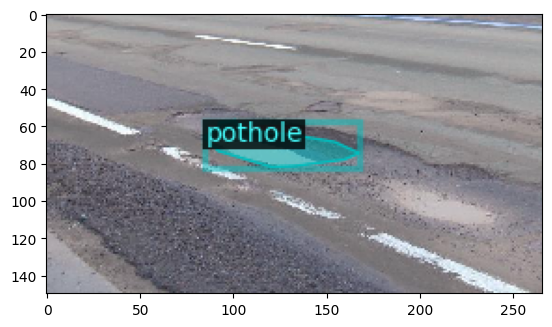

/content/Train_Images/img-538.jpg


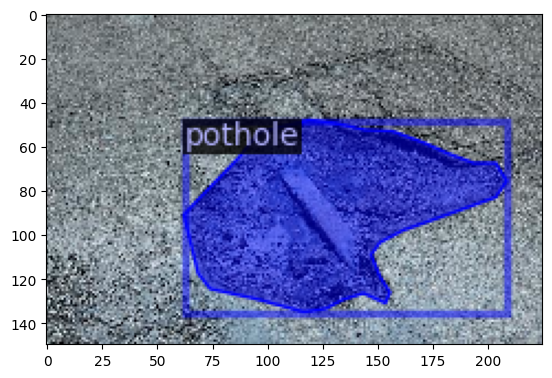

In [ ]:
for d in random.sample(train_dataset_dicts, 2):
    print(d['file_name'])
    img = cv2.imread(d['file_name'])
    viz = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = viz.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/Model"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00035  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[12/29 09:37:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 186MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train()

[12/29 09:37:59 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/29 09:38:13 d2.utils.events]:  eta: 0:16:29  iter: 19  total_loss: 1.608  loss_cls: 0.7266  loss_box_reg: 0.06883  loss_mask: 0.6915  loss_rpn_cls: 0.09228  loss_rpn_loc: 0.01892    time: 0.4169  last_time: 0.3103  data_time: 0.0218  last_data_time: 0.0055   lr: 6.9933e-06  max_mem: 2670M
[12/29 09:38:25 d2.utils.events]:  eta: 0:17:21  iter: 39  total_loss: 1.474  loss_cls: 0.5947  loss_box_reg: 0.08851  loss_mask: 0.6879  loss_rpn_cls: 0.07684  loss_rpn_loc: 0.01667    time: 0.4321  last_time: 0.2571  data_time: 0.0177  last_data_time: 0.0061   lr: 1.3986e-05  max_mem: 2670M
[12/29 09:38:33 d2.utils.events]:  eta: 0:16:44  iter: 59  total_loss: 1.185  loss_cls: 0.3463  loss_box_reg: 0.07065  loss_mask: 0.6785  loss_rpn_cls: 0.08145  loss_rpn_loc: 0.01559    time: 0.4226  last_time: 0.3127  data_time: 0.0154  last_data_time: 0.0106   lr: 2.0979e-05  max_mem: 2670M
[12/29 09:38:42 d2.utils.events]:  eta: 0:16:50  iter: 79  total_loss: 1.116  loss_cls: 0.2373  loss_box_reg: 0.1131  

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/29 09:58:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/Model/model_final.pth ...


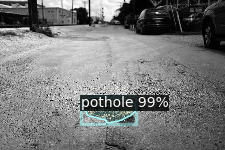

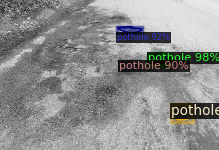

In [ ]:
from detectron2.utils.visualizer import ColorMode
from google.colab.patches import cv2_imshow

for d in random.sample(val_dataset_dicts, 2):    #select number of images for display
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/29 09:58:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/29 09:58:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 09:58:45 d2.data.datasets.coco]: Loaded 99 images in COCO format from /content/val_coco.json
[12/29 09:58:45 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  pothole   | 290          |
|            |              |
[12/29 09:58:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/29 09:58:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/29 09:58:45 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[12/29 09:58:45 d2.data.common]: Serialized da

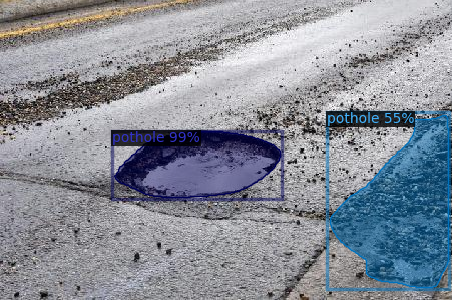

In [ ]:
new_im = cv2.imread("/content/img-665.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=MetadataCatalog.get("my_dataset_train"))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install -r requirements.txt

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-j5725ozo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-j5725ozo
  Resolved https://github.com/facebookresearch/detectron2.git to commit e9f7e2ba15abd7badcb05ef6f5076f06b36a9c5b
  Preparing metadata (setup.py) ... done


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.541s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
!pip install -q streamlit

In [ ]:
%%writefile main.py

import streamlit as st
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import os

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

CLASSES = ['pothole']

train_metadata = MetadataCatalog.get("my_dataset_train")

def load_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.MODEL.WEIGHTS = "/content/Model/model_final.pth"
    cfg.MODEL.DEVICE = 'cpu'

    return cfg


def inference(predictor, img):
    return predictor(img)


def visualize_output(cfg, img, outputs):
    v = Visualizer(img[:, :, ::-1], train_metadata, scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    st.image(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)


def discriminate(outputs):
    pred_classes = np.array(outputs['instances'].pred_classes)
    mask = np.isin(pred_classes, CLASSES)
    idx = np.nonzero(mask)

    out_fields = outputs['instances'].get_fields()
    for field in out_fields:
        out_fields[field] = out_fields[field][idx]

    return outputs


def main():
    st.title("Pothole Detection")
    file = st.file_uploader('',type = ['jpg','png','jpeg'])
    if file is not None:
      image = Image.open(file).convert('RGB')
      image = image.save("image.jpg")
      img = cv2.imread("image.jpg")
      cfg = load_cfg()
      predictor = DefaultPredictor(cfg)
      outputs = inference(predictor, img)
      visualize_output(cfg, img, outputs)


if __name__ == "__main__":
    main()

Overwriting main.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.184.152.7


In [ ]:
!streamlit run main.py & npx localtunnel --port 8501

[..................] \ fetchMetadata: sill resolveWithNewModule localtunnel@2.0


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.184.152.7:8501

npx: installed 22 in 1.84s
your url is: https://calm-wings-mix.loca.lt
2023-12-29 11:14:11.474 `label` got an empty value. This is discouraged for accessibility reasons and may be disallowed in the future by raising an exception. Please provide a non-empty label and hide it with label_visibility if needed.
2023-12-29 11:14:17.308 `label` got an empty value. This is discouraged for accessibility reasons and may be disallowed in the future by raising an exception. Please provide a non-empty label and hide it with label_visibility if needed.
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:34

In [ ]:
pip install flask-ngrok